# LIGO - Gravitational Waves Detectability

## Part 1 : Reproduce Paper Results

In [1]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings
from LIGO_Utils.LigoUtils import plot_training_history

In [2]:
def plot_results(history, title=''):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results"+f"\{title}"+".png")
    plt.show()

Loading downsampled data with unbalanced classes

In [3]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\y_ds_100k.npy")
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\data_ds_100k.npy")
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\keys.npy")

In [4]:
print(f'Detectable signals : {len(y[y==1])/len(y) * 100 :.3}%')

Detectable signals : 14.7%


We are looking for pretty rare signals, but not that rare actually...But first of all we have to rescale data and separate btw train and test set

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [6]:
S = RobustScaler().fit_transform(data)

In [7]:
S_train, S_test, y_train, y_test = train_test_split(S, y, test_size=0.2, shuffle=True, random_state=137)

Text(0.5, 1.0, 'Robust scaling')

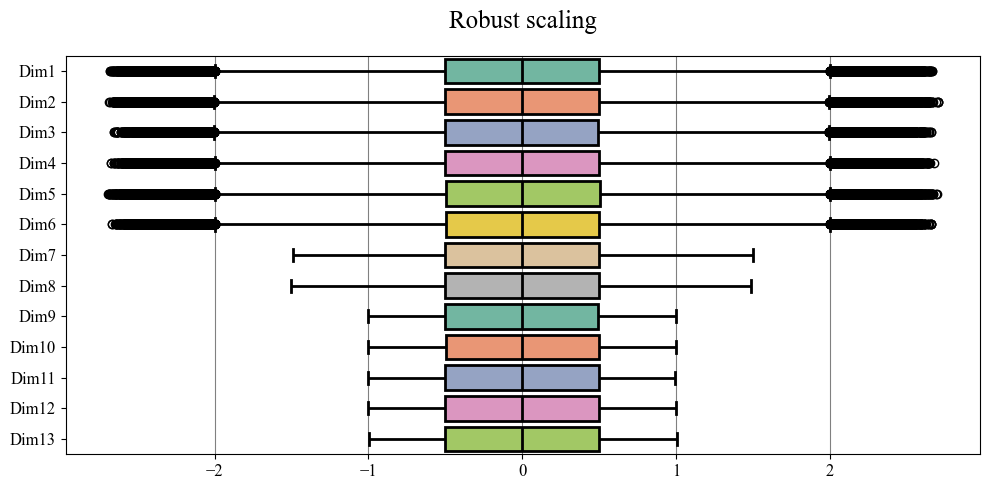

In [8]:
df = pd.DataFrame(S, columns=[f'Dim{i}' for i in range(1, 14)])

# Plot distributions
sns.boxplot(data=df, orient="h", palette="Set2", linecolor='k', linewidth=2)
plt.title("Robust scaling")

Define the model described in the paper "https://arxiv.org/pdf/2007.06585":
 - $1^{st}$ layer : 13 neurons
 - $2^{nd}$ layer : 32 neurons
 - $3^{rd}$ layer : output

ReLU activation function in inner layers and sigmoid activation function for outer layer.
Define the model

In [9]:
import keras.backend as k

In [17]:
k.clear_session()

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

model = Sequential([
    Input(shape=(13,)),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform'),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Adam optimizer with learning rate 0.01
adam = Adam(learning_rate=0.01)

model.compile(optimizer=adam,  loss='binary_crossentropy',  metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Fit the model
history = model.fit(
    S_train,         # input features
    y_train,         # target labels
    epochs=150,      # number of passes over the data
    batch_size=32,   # number of samples per gradient update
    validation_data = (S_test, y_test),  
    verbose=1
)

Epoch 1/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9331 - loss: 0.1512 - val_accuracy: 0.9560 - val_loss: 0.0960
Epoch 2/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9597 - loss: 0.0912 - val_accuracy: 0.9632 - val_loss: 0.0858
Epoch 3/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9625 - loss: 0.0873 - val_accuracy: 0.9659 - val_loss: 0.0775
Epoch 4/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9655 - loss: 0.0787 - val_accuracy: 0.9683 - val_loss: 0.0729
Epoch 5/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9688 - loss: 0.0734 - val_accuracy: 0.9692 - val_loss: 0.0724
Epoch 6/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9701 - loss: 0.0700 - val_accuracy: 0.9707 - val_loss: 0.0688
Epoch 7/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9716 - loss: 0.0673 - val_accuracy: 0.9672 - val_loss: 0.0741
Epoch 8/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9724 - lo

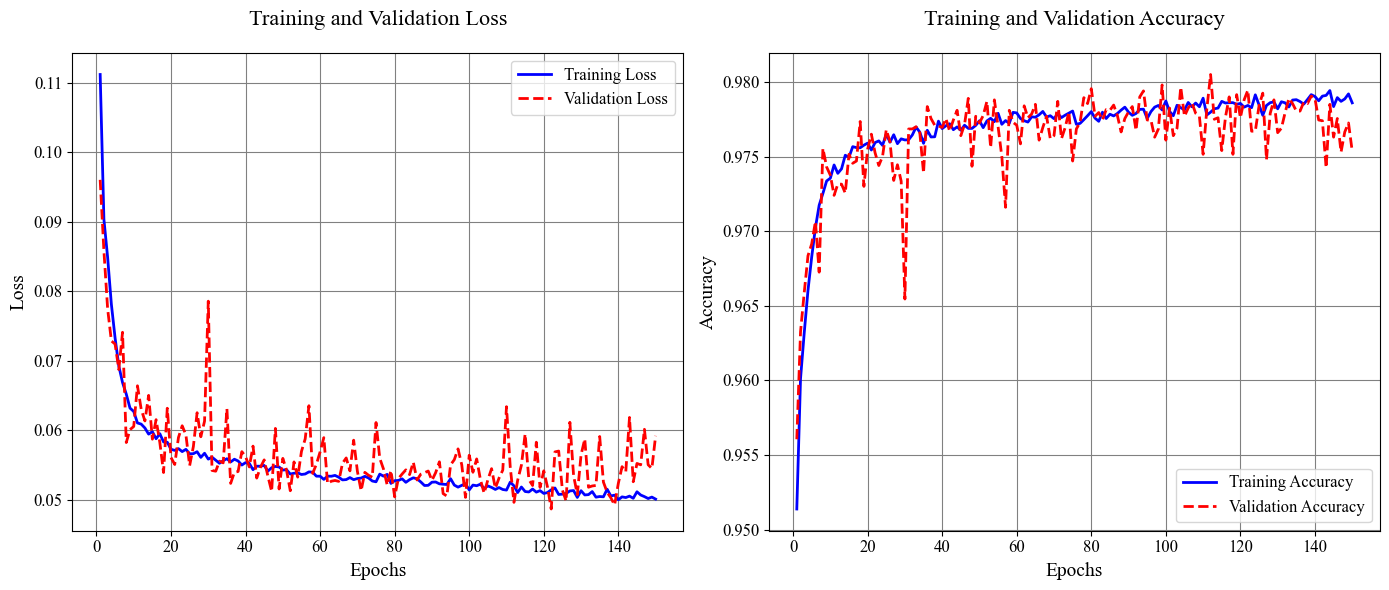

In [14]:
plot_results(history, 'model1')

In [15]:
with open(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results\model1_training_history.json', 'w') as f:
    json.dump(history.history, f)

**Overfiffing alarm goes on!!**: High fluctuations of validation loss and accuracy are a symphtom of overfitting...I can lower the learning rate as the number of epochs reaches 10-isch

In [18]:
import tensorflow as tf

class LRTLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

In [19]:
model = Sequential([
    Input(shape=(13,)),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform'),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Adam optimizer with learning rate 0.01
adam = Adam(learning_rate=0.01)

model.compile(optimizer=adam,  loss='binary_crossentropy',  metrics=['accuracy'])

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)
reduce_lr = LearningRateScheduler(scheduler)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
lr_tracker = LRTLogger()

In [23]:
history2 = model.fit(
    S_train, y_train,
    validation_data=(S_test, y_test),
    epochs=150,
    callbacks=[early_stop, reduce_lr, lr_tracker],
    verbose=1
)

Epoch 1/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9349 - loss: 0.1516 - val_accuracy: 0.9564 - val_loss: 0.0958 - learning_rate: 0.0100
Epoch 2/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9604 - loss: 0.0911 - val_accuracy: 0.9603 - val_loss: 0.0887 - learning_rate: 0.0100
Epoch 3/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9621 - loss: 0.0877 - val_accuracy: 0.9613 - val_loss: 0.0880 - learning_rate: 0.0100
Epoch 4/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9636 - loss: 0.0842 - val_accuracy: 0.9643 - val_loss: 0.0816 - learning_rate: 0.0100
Epoch 5/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9648 - loss: 0.0800 - val_accuracy: 0.9667 - val_loss: 0.0755 - learning_rate: 0.0100
Epoch 6/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9673 - loss: 0.0750 - val_accuracy: 0.9657 - val_loss: 0.0766 - learning_rate: 0.0100
Epoch 7/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0

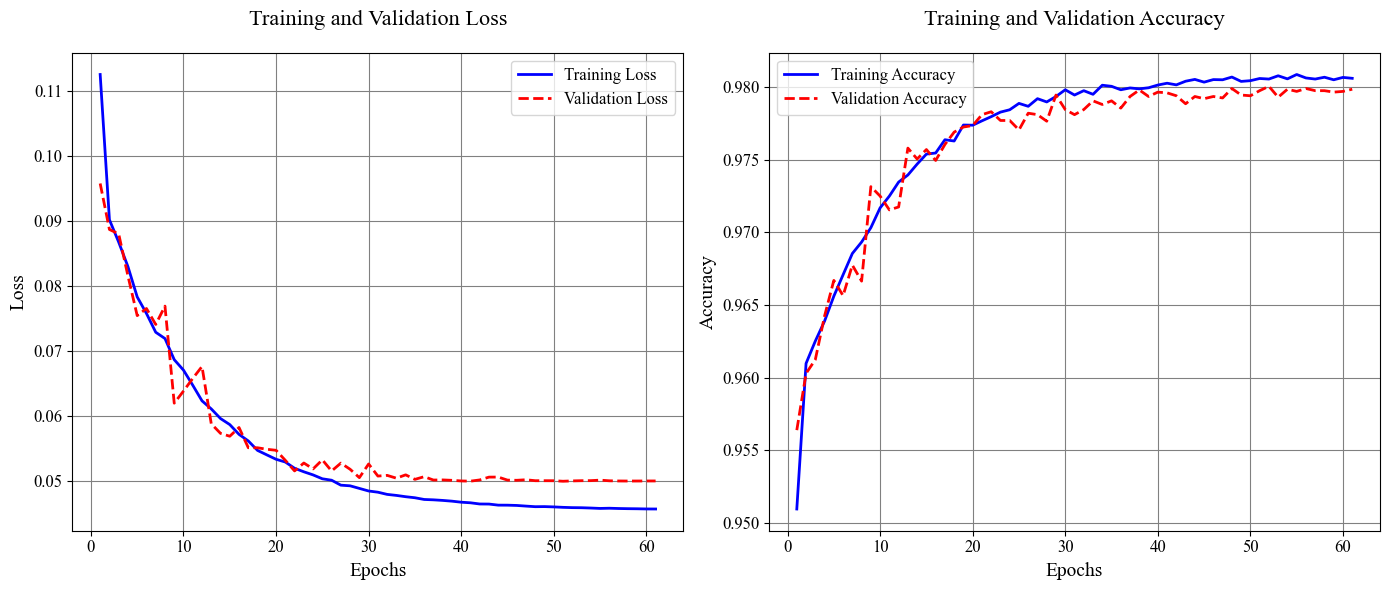

In [24]:
plot_results(history2, 'model2')

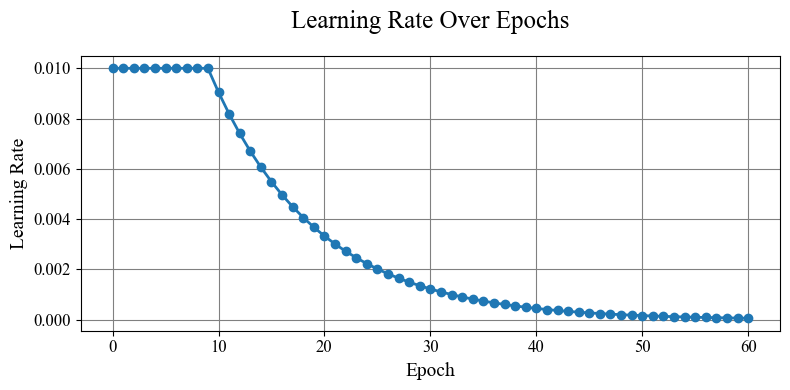

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(lr_tracker.lrs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.savefig('lr_model3')

Learning rate did reduce exponentially, good! Now I'd like to visualize the predictive power of the last model

In [27]:
probs = model.predict(S_test)  # shape will be (n_samples, 1)
probs = probs.flatten()       # shape becomes (n_samples,)
# Compute p(y=1 | x)
p_y1 = probs
# Compute p(y=0 | x)
p_y0 = 1 - probs

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [52]:
len(probs[y_test == 1])/len(probs)

0.14625

Which is very close to the actual detectable signals percentage

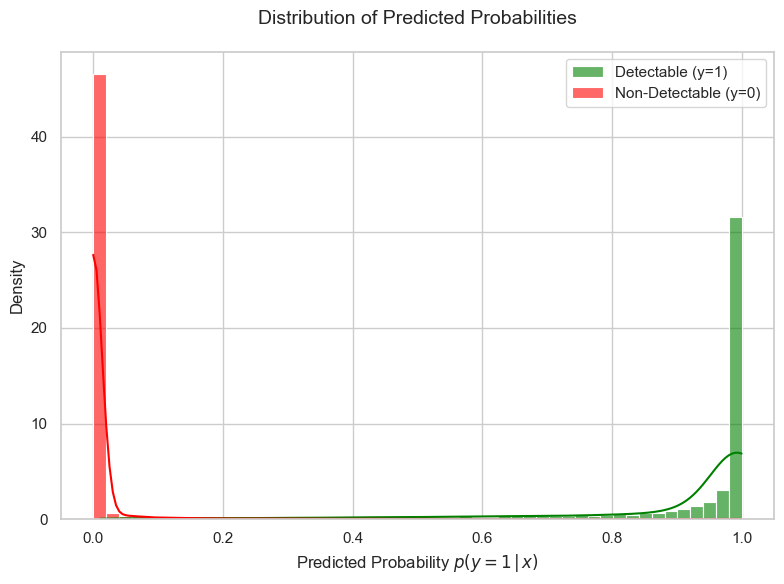

In [48]:
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.histplot(probs[y_test == 1], bins=50, kde=True, color='green', label='Detectable (y=1)', stat='density', alpha=0.6)
sns.histplot(probs[y_test == 0], bins=50, kde=True, color='red', label='Non-Detectable (y=0)', stat='density', alpha=0.6)

plt.xlabel('Predicted Probability $p(y=1\,|\,x)$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Predicted Probabilities', fontsize=14)
plt.legend()

Am I really sure that the signals labelled as "detectable" are actually detectable?\
To see such a thing I could look at the calibration plot, were I'll plot the fraction of true positives against the mean predicted probabilities

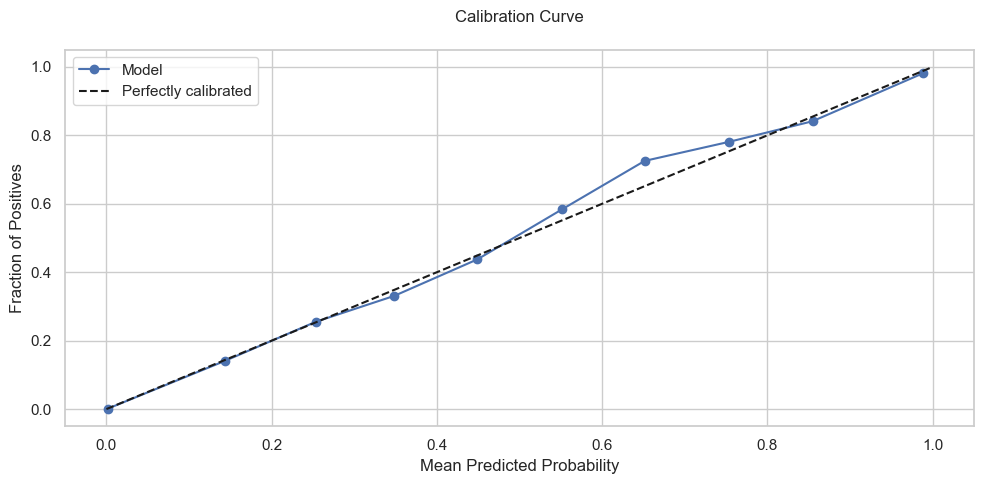

In [35]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This is a very clean and good calibration curve! The model underestimates the number of predicted true positives if the frequency of true positives is in the intervall $[0.6 - 0.8]$.

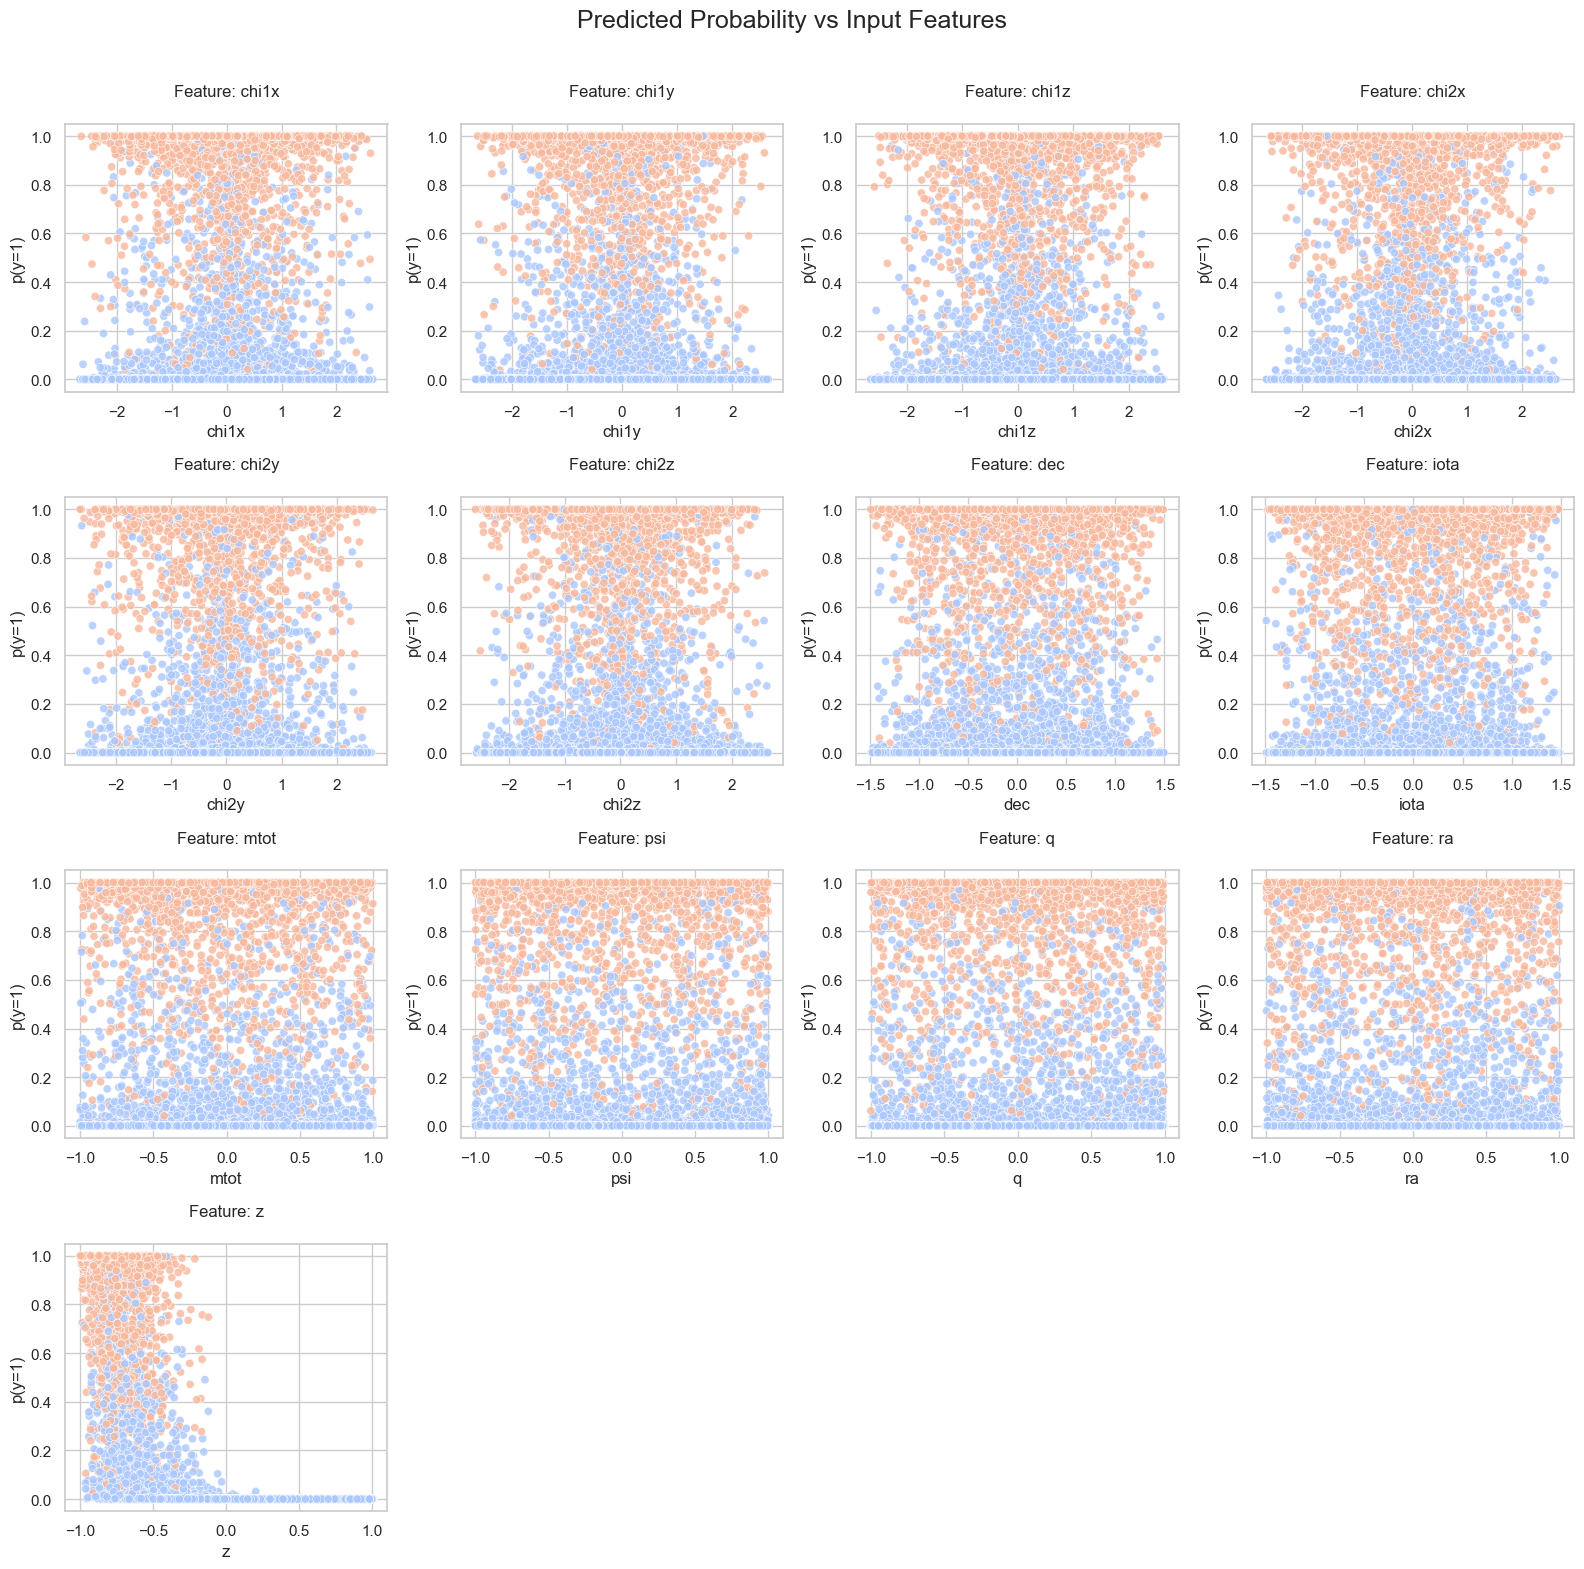

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume:
# - S_test has shape (n_samples, 13)
# - probs is (n_samples,)
# - y_test is binary labels (n_samples,)
# - keys is a list of 13 feature names

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(16):
    if i < 13:  # We only have 13 features
        sns.scatterplot(
            x=S_test[:, i],
            y=probs,
            hue=y_test,
            palette='coolwarm',
            alpha=0.8,
            ax=axes[i],
            legend=False  # Disable legend to avoid repetition
        )
        axes[i].set_xlabel(keys[i])
        axes[i].set_ylabel('p(y=1)')
        axes[i].set_title(f'Feature: {keys[i]}')
        axes[i].grid(True)
    else:
        axes[i].axis('off')  # Empty plots for extra 3 subplots

plt.suptitle("Predicted Probability vs Input Features", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


My interpretation of the plot above is that extrinsic variables like ra, dec, psi, iota are not aligned with classes.\
I think it's a good idea to marginalize over those extrinsic variables to concentrate on the intrinsic ones.\
I'll use MonteCarlo integration to reach this goal.\
But before all of this, I'd like to try tuning hyperparameters, expetially regularization rate and learning rate

## Hyperparameters tuning

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.regularizers import l1
from keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential([
        Input(shape=(13,)),
        Dense(
            32,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l1(hp.Float('l1_reg', 1e-5, 1e-2, sampling='log'))
        ),
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [83]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory=r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results\keras_tuner_dir',
    project_name='regularized'
)

reduce_lr = LearningRateScheduler(scheduler)

tuner.search(S_train, y_train, 
             epochs=30, 
             validation_data = (S_test, y_test),
             callbacks=[early_stop, reduce_lr, lr_tracker])

Trial 7 Complete [00h 04m 36s]
val_loss: 0.08718539774417877

Best val_loss So Far: 0.07766979932785034
Total elapsed time: 00h 30m 20s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
0.0040218         |0.00011383        |l1_reg
0.0033277         |0.0037234         |lr

Epoch 1/30
1880/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.3107

KeyboardInterrupt: 

In [84]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

In [87]:
best_trial.summary()

Trial 05 summary
Hyperparameters:
l1_reg: 0.00011383387339894534
lr: 0.003723448197404828
Score: 0.07766979932785034


In [90]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\tf-venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [92]:
best_model.evaluate(S_test, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9706 - loss: 0.0780


[0.07766979932785034, 0.9701499938964844]

## Marginalize over extrinsic variables

In [129]:
def sample_extrinsic():
    ra = np.random.uniform(-1, 1)
    dec = np.random.uniform(-1, 1)
    psi = np.random.uniform(-1, 1)
    iota = np.random.uniform(-1, 1)
    return np.array([ra, dec, psi, iota])


def marginalize(model, intrinsic_sample, N=100):
    extrinsic_samples = np.array([sample_extrinsic() for _ in range(N)])
    full_inputs = np.hstack([np.repeat(intrinsic_sample.reshape(1, -1), N, axis=0), extrinsic_samples])
    preds = model.predict(full_inputs, verbose=0)[:, 0]
    return np.mean(preds)


In [130]:
intrinsic_features = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'mtot', 'q', 'z']
extrinsic_features = ['ra', 'dec', 'psi', 'iota']
intrinsic_idx = np.where(np.isin(keys, intrinsic_features))[0]

In [131]:
A = np.vstack([S_test[:, keys=='ra'].T[0], 
              S_test[:, keys=='dec'].T[0],
              S_test[:, keys=='psi'].T[0],
              S_test[:, keys=='iota'].T[0]]).T

In [ ]:
from tqdm import tqdm

marginalized_probs = []

for i in tqdm(range(S_test.shape[0]), desc="Marginalizing"):
    intrinsic = S_test[i, intrinsic_idx]
    p_marg = marginalize(model, intrinsic, N=100)
    marginalized_probs.append(p_marg)

Marginalizing:   0%|          | 29/20000 [00:04<42:49,  7.77it/s]  

In [ ]:
marginalized_probs = np.array(marginalized_probs)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, marginalized_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Marginalized ROC (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()

In [ ]:
from sklearn.metrics import classification_report

threshold = 0.5
pred_labels = (marginalized_probs >= threshold).astype(int)

print(classification_report(y_test, pred_labels))

In [ ]:
z_idx = np.where(keys == 'z')[0][0]
z_values = S_test[:, z_idx]

plt.scatter(z_values, marginalized_probs, alpha=0.5, s=10)
plt.xlabel("Redshift z")
plt.ylabel("p(y=1 | intrinsic)")
plt.title("Marginalized prediction vs Redshift")
plt.grid()